In [1]:
import pandas as pd
import numpy as np
import re
import os 
import matplotlib.pyplot as plt
output_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'data/firing_rates'))
import seaborn as sns
sns.set_style("darkgrid")
import ssm 
from ssm.plots import gradient_cmap
import yaml
import itertools

In [2]:
# colors and color plates 

color_names = [
    "windows blue",
    "faded green"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [48]:
# functions

def load_firing_rates(output_dir, file_name):
    """
    Load data of firing rates
    output_dir: folder where the firing rates are saved
    Returns: Data Frame with state for all regions 
    """
    
    # load data 
    frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE_{file_name}.csv'))
    frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI_{file_name}.csv'))
    frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA_{file_name}.csv')) 

    ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))
    return ratesG

def calc_HMM_states(firing_rate_I):
    '''
    Calculate the Up and down states of a time series
    '''
    
    # parameters for the HMM for finding Up and Down states 
    K = 2    # number of discrete states
    D = 1    # dimension of the observations

    # make an hmm and sample from it
    simple_hmm = ssm.HMM(K, D, observations='gaussian')

    # Fit HMM on all data
    trial_data = np.expand_dims(np.array(firing_rate_I), axis=1)
    lls = simple_hmm.fit(trial_data, method='em', transitions='sticky')
    posterior = simple_hmm.filter(trial_data)
    zhat = simple_hmm.most_likely_states(trial_data)
    # check if 1 and 0 state has to be turned around
    # so that 1 is up and 0 is down 
    if np.mean(trial_data[zhat==0]) > np.mean(trial_data[zhat==1]):
        zhat = np.where((zhat==0)|(zhat==1), zhat^1, zhat)
        p_down = posterior[:, 1]
    else:
        p_down = posterior[:, 0]
    
    return zhat, p_down

def get_all_states(output_dir, file_name, save_states=True):
    """
    Compute the up and down states for all of the regions in this session.
    output_dir: folder where the firing rates are saved
    file_name: name of the csv file, without the rate specification
    Returns: Data Frame with state for all regions 
    """
    
    # load data 
    regions_states = pd.DataFrame()
    frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE_{file_name}.csv'))
    frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI_{file_name}.csv'))
    frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA_{file_name}.csv')) 

    ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))

    for i in range(ratesG.shape[2]):

        zhat, p_down = calc_HMM_states(ratesG[1, :, i])

        # safe the states in this dataframe
        regions_states = pd.concat((regions_states, pd.DataFrame(data={
        'state': zhat, 'p_down': p_down, 'region': i})))
    
    if save_states:
        regions_states.to_csv(os.path.join(output_dir, file_name+'_states.csv'))
    
    return regions_states


def plot_states_column(output_dir, file_name, stimulation=False):
    """
    Print the up and down state per region in one column 
    States: dataframe with state data
    Stimulation: wheter or not to also plot the serotonin stimulation on and offset.
    """
    
    # check if any files in the directory end with 'states.csv'
    if any(f.endswith('states.csv') for f in os.listdir(output_dir)):
        print('The folder contains a file with the ending "states.csv"')
    else:
        print('The folder does not contain a file with the ending "states.csv"')
        _ = get_all_states(output_dir, file_name)
        
    # load state data
    states = pd.read_csv(os.path.join(output_dir, file_name+'_states.csv'), index_col=0)
    
    # get the stimulation time file
    if stimulation:
        times_array = get_stimulation_window(output_dir, file_name)

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv('relevant_areas.csv')
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)

    fig, axes = plt.subplots(len(atlas), 1, sharex=True, sharey=False, figsize=(9,10))
    frame = plt.gca()
    frame.axes.get_yaxis().set_visible(False)
    
    for i, ax in enumerate(axes):

        
        if stimulation:
            ax.plot(states[states['region']==i]['state'])
            for stim_time in times_array.flatten():
                ax.axvline(stim_time, color='red')
            
        else: 
            ax.plot(states[states['region']==i]['state'])
            
        ax.set_title(atlas[i][0], y=0, x=1.15)
    
    fig.suptitle(file_name, fontsize=15)
    plt.tight_layout()
    plt.show()


def plot_multiarea_signal(output_dir, file_name, start=None, stop=None, stimulation=False, states=False):
    """
    Plot the time series for multiple areas.
    output_dir: folder where the firing rates are saved
    file_name: name of the csv file, without the rate specification
    start, stop: beginning and end of plotting the signal
    stimulation: wheter or not to also plot the serotonin stimulation on and offset.
    states: if true, also plot HMM states
    """
    
    frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE_{file_name}.csv'))
    frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI_{file_name}.csv'))
    frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA_{file_name}.csv')) 

    ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))
    
    # get the stimulation time file
    if stimulation:
        times_array = get_stimulation_window(output_dir, file_name) - start
    
    if states:
        # check if any files in the directory end with 'states.csv'
        if any(f.endswith('states.csv') for f in os.listdir(output_dir)):
            print('The folder contains a file with the ending "states.csv"')
        else:
            print('The folder does not contain a file with the ending "states.csv"')
            _ = get_all_states(output_dir, file_name)

        # load state data
        states = pd.read_csv(os.path.join(output_dir, file_name+'_states.csv'), index_col=0)
    
    # define the time window to plot
    start = 0 if not start else start
    stop = len(frate_I_sync) if not stop else stop
    
    # load atlas with releveant regions
    atlas = pd.read_csv('relevant_areas.csv')
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)
    fig, axes = plt.subplots(5, 3, sharex=True, sharey=False, figsize=(9,10))

    for i, ax in enumerate(axes.flatten()):
        if i==14:
            break

        ax.plot(ratesG[1,start:stop,i], label='I')
        ax.plot(ratesG[0,start:stop,i], label='E')
        ax.set_title(atlas[i][0])
        ax.legend()
        
        for stim_time in times_array.flatten():
                ax.axvline(stim_time, color='red')
            
        if isinstance(states, pd.DataFrame):
            data = states[states['region']==i][start:stop].reset_index()
            ax.plot(data['state'], color='pink')
            lim = 1.05 * abs(ratesG[1,start:stop,i]).max()
            
            ax.imshow(np.expand_dims(data['state'], axis=0),
                       aspect="auto",
                       cmap=cmap,
                       #vmin=0,
                       #vmax=len(colors)-1,
                       extent=(0, len(ratesG[1,start:stop,i]), -2, lim))

    fig.suptitle(file_name, fontsize=15)
    plt.tight_layout()
    
    if not isinstance(states, pd.DataFrame):
        plt.savefig(os.path.join(output_dir, file_name+ '.pdf')) 
    else:
        plt.savefig(os.path.join(output_dir, file_name+ '_states.pdf'))
    

def compute_brunel_x(output_dir, file_name):
    """
    Quantify synchrony of the network by computing the parameter X as defined in Brunel & Hansel (2006).
    """
    
    # load the activity for the inhibitory poputations
    _, ratesI, _ = load_firing_rates(output_dir, file_name)
    
    # get infos about session (for saving it later)
    G, _ = extract_file_info(output_dir, file_name)
    
    # compute the variance of the population averaged activity
    network_rate_mean_pertime = np.mean(ratesI, axis=1)
    network_rate_mean_perregion = np.mean(ratesI, axis=0)

    # this is the same as np.var(network_rate_mean_pertime)
    network_variance = np.mean((network_rate_mean_pertime)**2) - np.mean(network_rate_mean_pertime)**2
    print('network variance:', network_variance)

    # calculate the variance of each area individually 
    # the individual variance is completely independent of the other region's variance 
    individual_variance = np.mean((ratesI)**2) - np.mean(ratesI)**2

    # X parameter
    # if the average individual variance is similar to the overall regions variance 
    mean_individual_var = np.mean(individual_variance)
    print('average of individual variance:', mean_individual_var)

    brunel_x = np.sqrt(network_variance/mean_individual_var)
    print('synchrony:', brunel_x)
    
    return pd.DataFrame(data={'brunel_X': brunel_x, 'G' : G}, index=[0])
    
    
def compute_state_analysis(output_dir, file_name):
    """
    File should be the From the data frame with state info calculate the most important parameter for every 
    region time series.
    G value, thetaE, beta, thetaE stimulation, serotonin stimulation times, and the most important parameters:
    Description of the parameters:
    f_s - frequency of states
    d_down - average duration of down-states
    d_up - average duration of up-states
    p_down - proportion time in state 0
    p_up - proportion time in state 1 
    brunel_X - quantifies synchrony: 0 low, 1 high
    """

    region_states = pd.read_csv(os.path.join(output_dir, f'{file_name}_states.csv'))
    state_statistics = pd.DataFrame()
    
    # get infos about session (for saving it later)
    G, _ = extract_file_info(output_dir, file_name)

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv('relevant_areas.csv')
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)
    
    for i, region in enumerate(np.unique(region_states['region'])):
    
        # get the time series for this region
        time_series = list(region_states[region_states['region']==region]['state'])
        trial_duration = len(time_series)

        # count the number of occurrences of 0 and 1
        num_zeros = time_series.count(0)
        num_ones = time_series.count(1)

        # calculate the duration of each state (in number of time steps)
        zero_durations = [sum(1 for _ in group) for key, group in itertools.groupby(time_series) if key == 0]
        one_durations = [sum(1 for _ in group) for key, group in itertools.groupby(time_series) if key == 1]
                
        # calculate the frequency of the states (I use the up-state here) 
        f_s = (len(one_durations)/trial_duration)*1000
        
        # calculate the average state durations 
        d_down = np.mean(zero_durations)
        d_up = np.mean(one_durations)

        # calculate the total duration of each state (in number of time steps)
        total_zero_duration = sum(zero_durations)
        total_one_duration = sum(one_durations)

        # calculate the proportion of time spent in each state
        prop_zero = total_zero_duration / len(time_series)
        prop_one = total_one_duration / len(time_series)

        # collect the values in the dataframe 
        state_statistics = pd.concat((state_statistics, pd.DataFrame(data={'state_frequency': f_s, 'd_down': d_down,
                                                                           'd_up' : d_up, 'p_down' : prop_zero,
                                                                           'p_up' : prop_one,
                                                                           'region': atlas[i][0], 'G' : G}, index=[0])))
        
    return state_statistics

     
def plot_session_statistics(state_statistics):
    """
    For one simulation session (with the same G and S value) plot the state statistics,
    so that makes one plot per parameter (e.g., frequency, average duration, ...).
    """

    # per parameter plot the values for each region
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,9))

    sns.pointplot(state_statistics, x='region', y='state_frequency', ax=axes[0], join=False)
    sns.pointplot(state_statistics, x='region', y='d_up', ax=axes[1], join=False)
    sns.pointplot(state_statistics, x='region', y='d_down', ax=axes[2], join=False)
    axes[2].set_xticklabels(np.unique(state_statistics['region']), rotation = 90)
    for ax in axes:
        ax.label_outer()
    plt.show()


def plot_parameter_statistics(state_statistics, regions='all'):
    """
    For different G parameters plot all state parameters (e.g., frequency, average duration, ...)
    """

    if regions == 'all':
        plot_regions = np.unique(state_statistics['region'])
    else:
        plot_regions = np.unique(state_statistics[state_statistics['region'].isin(regions)]['region'])
        
    nr_regions = len(regions)
    fig, axes = plt.subplots(nr_regions, 3, sharex=True, sharey=False, figsize=(10, 5))
    
    for i, region in enumerate(plot_regions):

        region_stats = state_statistics[state_statistics['region']==region]

        axes[i][0].set_title('state_frequency', fontsize=18)
        axes[i][0].plot(region_stats['G'], region_stats['state_frequency'])
        axes[i][0].set_ylabel('Hz')
        
        axes[i][1].set_title(region+'\naverage state duration', fontsize=18)
        axes[i][1].plot(region_stats['G'], region_stats['d_down'], label='down')
        axes[i][1].plot(region_stats['G'], region_stats['d_up'], label='up')
        axes[i][1].set_ylabel('ms')
        axes[i][1].legend()

        axes[i][2].set_title('proportion of trial time', fontsize=18)
        axes[i][2].plot(region_stats['G'], region_stats['p_down'], label='down')
        axes[i][2].plot(region_stats['G'], region_stats['p_up'], label='up')
        axes[i][2].set_ylabel('percentage (%)')
        axes[i][2].legend()
        #plt.title(atlas[i][0], y=0, x=1.5) 

    plt.tight_layout()

    
def get_stimulation_window(output_dir, file_name):
    """
    Get the start and stop time stamp of every stimulation window.
    """
    
    # get the stimulation time file
    stimulation_times = pd.read_csv(os.path.join(output_dir, file_name+'_stimulation_times.csv'))['0'].to_numpy()    
    groups = []
    for k, g in itertools.groupby(enumerate(stimulation_times), lambda i_x:i_x[0]-i_x[1]):
        group = list(map(lambda i_x:i_x[1], g))
        groups.append((group[0], group[-1]))

    times_array = np.array(groups)
    return times_array


def compute_stimulation_parameter(output_dir, file_name):
    """
    From the HMM state of a session, quantify the effect of serotonin stimulation on up and down states.
    For this we compute the duration until the next state change after start and stop of stimulation.
    """
    
    # check if any files in the directory end with 'states.csv'
    if any(f.endswith('states.csv') for f in os.listdir(output_dir)):
        print('The folder contains a file with the ending "states.csv"')
    else:
        print('The folder does not contain a file with the ending "states.csv"')
        _ = get_all_states(output_dir, file_name)
    
    # get the stimulation start and stop values 
    times_array = get_stimulation_window(output_dir, file_name)
    state_data = pd.read_csv(os.path.join(output_dir, file_name+'_states.csv'), index_col=0)

    # get infos about session (for saving it later)
    G, S = extract_file_info(output_dir, file_name)

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv('relevant_areas.csv')
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)

    # data frame to save the values
    stimulation_parameter = pd.DataFrame()

    for region in range(len(atlas)):

        region_state = state_data[state_data['region']==region]['state']

        for time_window in times_array:
            start = time_window[0]
            stop = time_window[1]

            # duration until next state after start
            start_state = region_state[start]
            for time_point, curr_state in enumerate(region_state[start:], start=start):
                if curr_state != start_state:
                    dur_next_start = time_point - start
                    break

            # duration until next state after stimulation end                
            stop_state = region_state[stop]
            for time_point, curr_state in enumerate(region_state[stop:], start=stop):
                if curr_state != stop_state:
                    dur_next_stop = time_point - stop
                    break

            stimulation_parameter = pd.concat((stimulation_parameter, pd.DataFrame(data={'dur_next_start': dur_next_start,
                                                                     'start_state': start_state, 
                                                                     'dur_next_stop': dur_next_stop,
                                                                     'stop_state': stop_state, 'region': atlas[region],
                                                                     'G': G, 'S': S}, index=[0])))
    return stimulation_parameter

def extract_file_info(output_dir, file_name):
    
    # load settingsfile 
    settings_file = os.path.join(output_dir, file_name+'_expsettings.yml')
    
    with open(settings_file, 'r', encoding='utf8') as f_in:
        settings = yaml.safe_load(f_in)
        
    G = settings['Parameter']['G']
    S = settings['Parameter']['S']
    
    return [G, S]

#### Multi area model  
Extended single ara model, replicated from Jercog et al. 2017

In [ ]:
file_name_add = '_5areas'
frate_E = pd.read_csv(os.path.join(output_dir, f'frateE{file_name_add}.csv'))
frate_I = pd.read_csv(os.path.join(output_dir, f'frateI{file_name_add}.csv'))
frate_A = pd.read_csv(os.path.join(output_dir, f'frateA{file_name_add}.csv'))

file_name_add = '_5areas_G1'
frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE{file_name_add}.csv'))
frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI{file_name_add}.csv'))
frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA{file_name_add}.csv'))

In [ ]:
# make a multidim array with all the firing rates
rates = np.array((frate_E, frate_I, frate_A))
ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))

In [ ]:
# plot in a row all rates and adaptation trajectories

fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10,14))

for i, ax in enumerate(axes):
    ax[0].plot(rates[0,:,i], label='E', )
    ax[0].plot(rates[1,:,i], label='I')
    ax[1].plot(rates[2,:,i], label='A', color='black')
    ax[0].legend() 
    ax[1].legend() 
    
plt.savefig('5areas_G-0.pdf')
plt.show()

In [ ]:
# plot in a row all rates and adaptation trajectories

fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(12,14))

for i, ax in enumerate(axes):
    ax[0].plot(ratesG[0,:,i], label='E', )
    ax[0].plot(ratesG[1,:,i], label='I')
    ax[1].plot(ratesG[2,:,i], label='A', color='black')
    ax[0].legend() 
    ax[1].legend() 
    
plt.savefig('5areas_G-1_Cmatrix-1.pdf')

In [ ]:
# looping over nd array
test = np.array((np.arange(5), np.arange(5, 10), np.arange(10, 15), np.arange(15, 20), np.arange(20, 25)))
np.fill_diagonal(test, 0)
test_b = np.zeros((5,5))
test_b[2][1] = 11 # to area 2 from area 1 it is connected with the strength 11
rate_example = np.array([1, 10, 25, 2, 5])
print(rate_example.shape)

In [ ]:
# this is to calculate the influence of area 1 on area 2
# it computes the value for area 2 
np.matmul(test_b, rate_example)

### Multi area 
14 areas, connected with allen brain atlas data

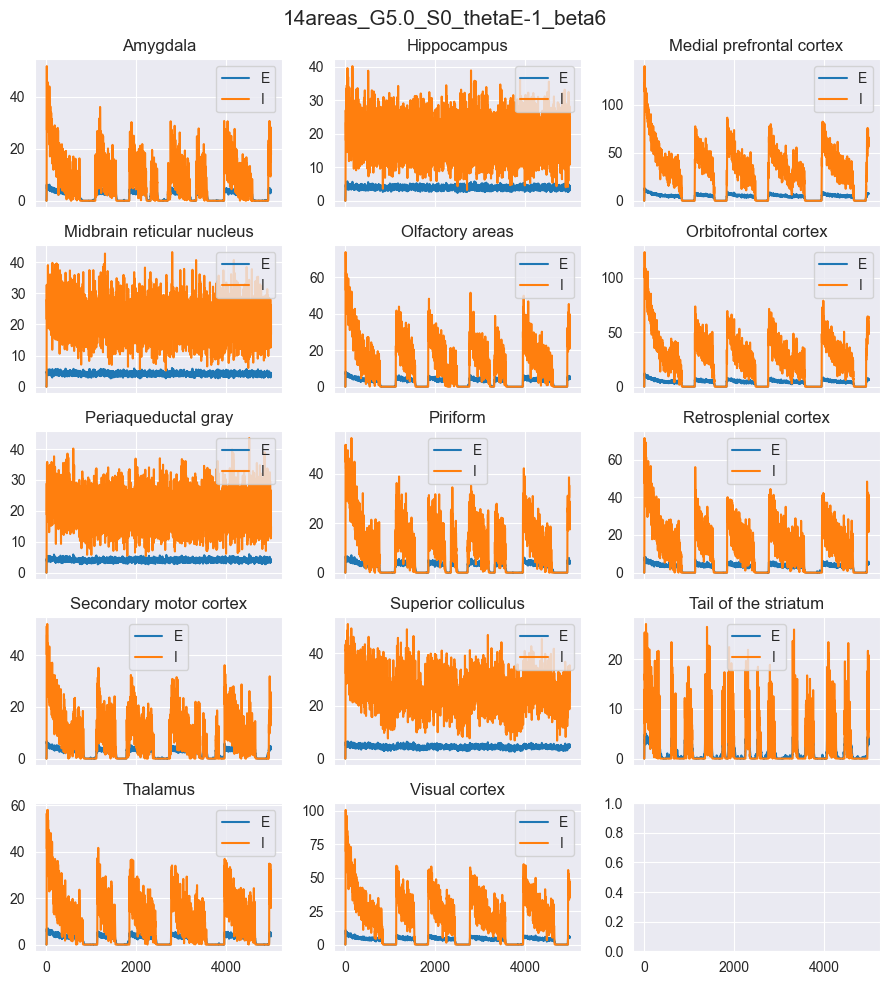

In [16]:
# plot signal of all regions for one simulation session
G = 5
S = 0
beta = 6
thetaE = -1
extra = ""
start = 0
stop = 5000
file_name = f'14areas_G{float(G)}_S{S}_thetaE{thetaE}_beta{beta}{extra}'
file_dir = os.path.join(output_dir, file_name)
plot_multiarea_signal(file_dir, file_name, start, stop)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

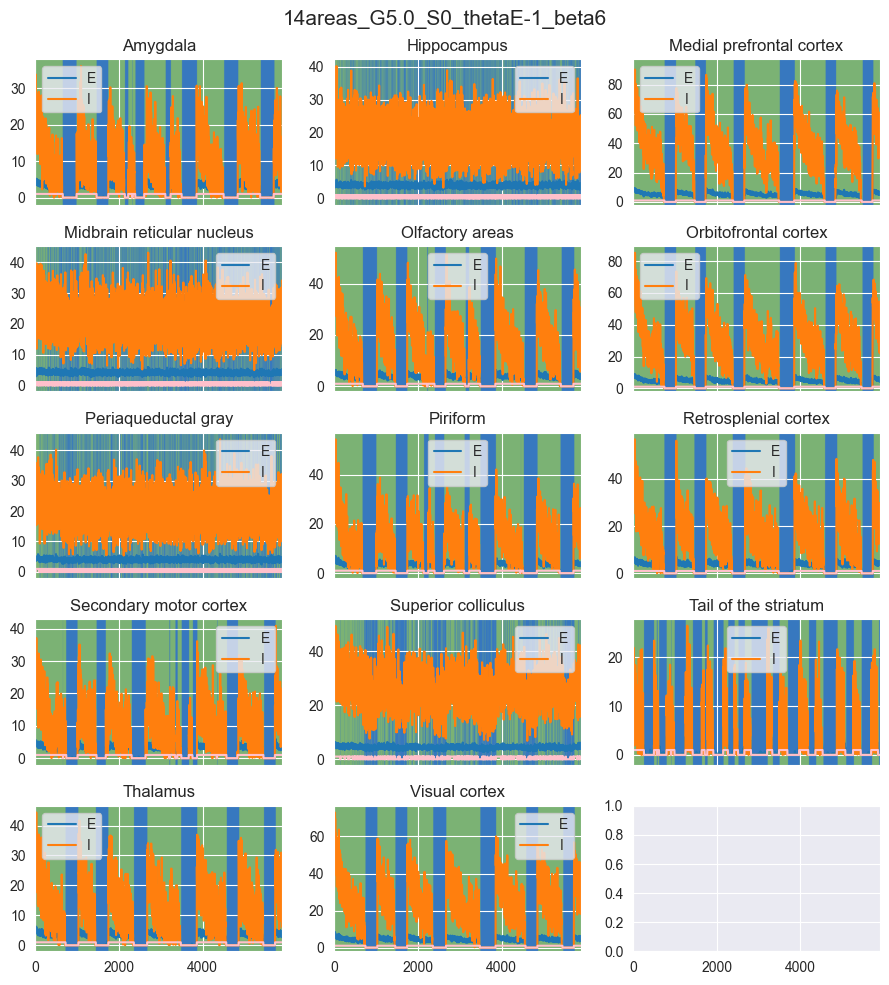

In [17]:
# compute the states of all regions and plot it together with the signal 
state_data = get_all_states(file_dir, file_name)
start = 100
stop = 6000
plot_multiarea_signal(file_dir, file_name, start, stop, states=state_data)

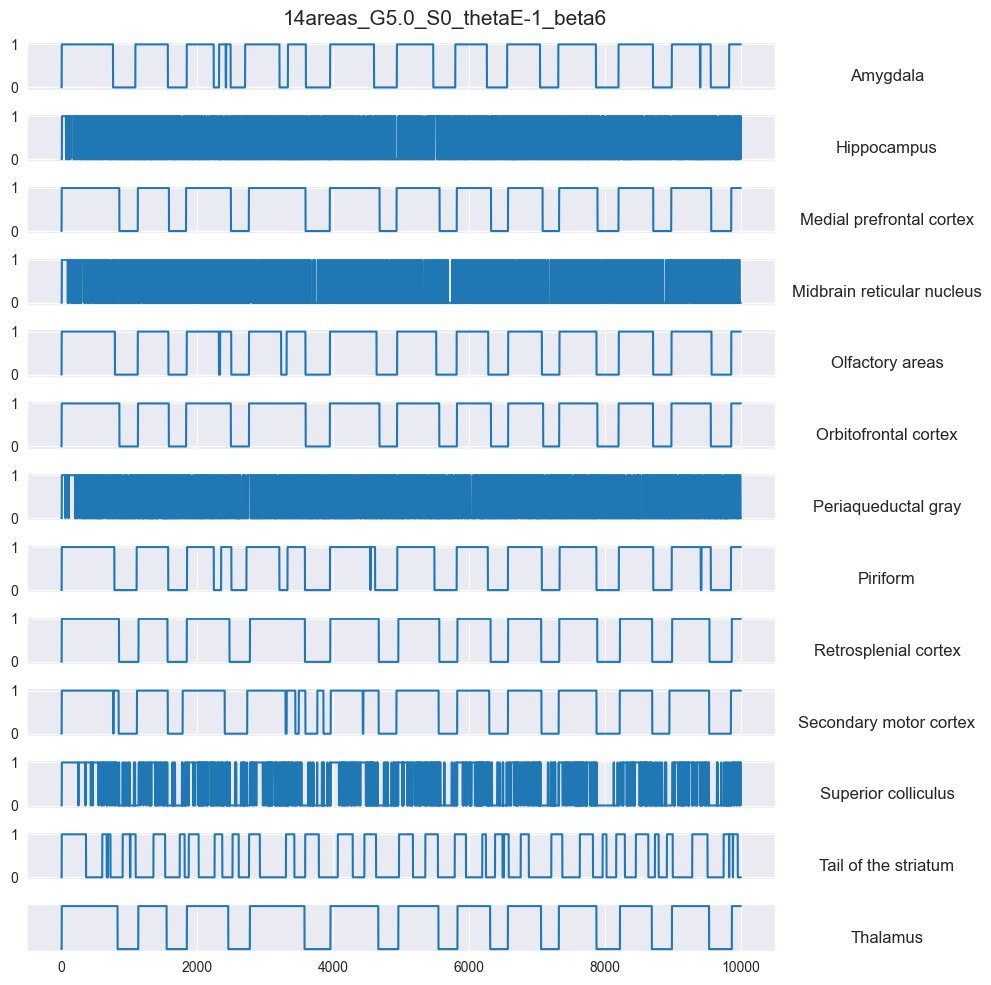

In [18]:
# plot the states of all regions in a column on top of each other
plot_states_column(file_dir, file_name)


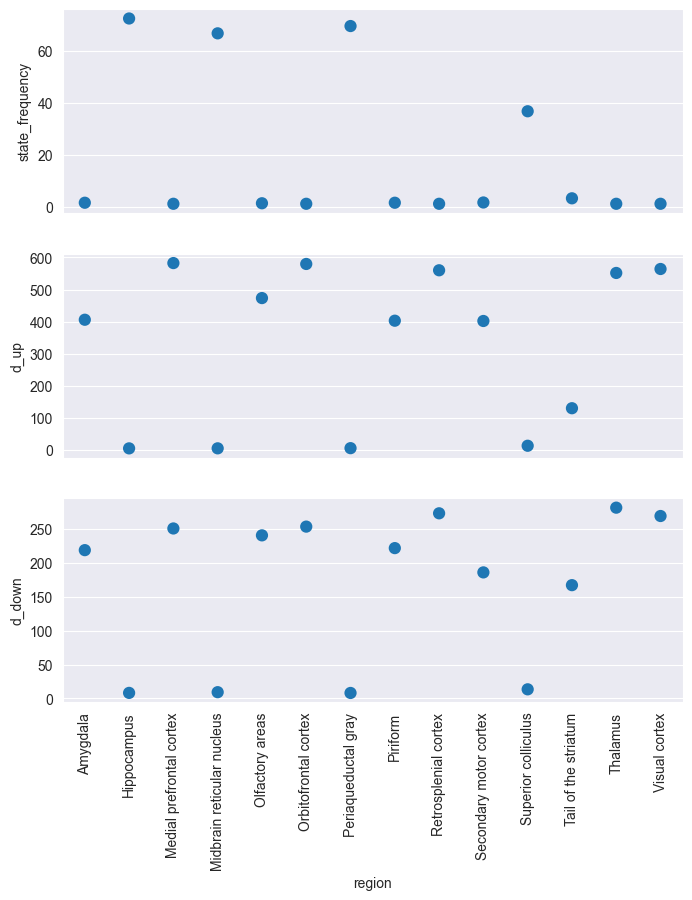

In [19]:
# compute the analysis of the states 
state_statistics = compute_state_analysis(file_dir, file_name)
plot_session_statistics(state_statistics)

In [30]:
# calculate the states and synchrony quantification (brunel X parameter) for many different G values 
G_parameters = np.arange(1, 10, 1)
all_analyses = pd.DataFrame()
brunel_X_df = pd.DataFrame()
for G in G_parameters:
    G_param = np.round(G, 1)
    file_name = f'14areas_G{G_param}_S{S}_thetaE{thetaE}_beta{beta}{extra}'
    file_dir = os.path.join(output_dir, file_name)
    #_ = get_all_states(file_dir, file_name)
    brunel_X_df = pd.concat((brunel_X_df, compute_brunel_x(file_dir, file_name)))
    all_analyses = pd.concat((all_analyses, compute_state_analysis(file_dir, file_name)))


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

network variance: 26.963349422764992
average of individual variance: 102.01384219931346
synchrony: 0.514111557870343


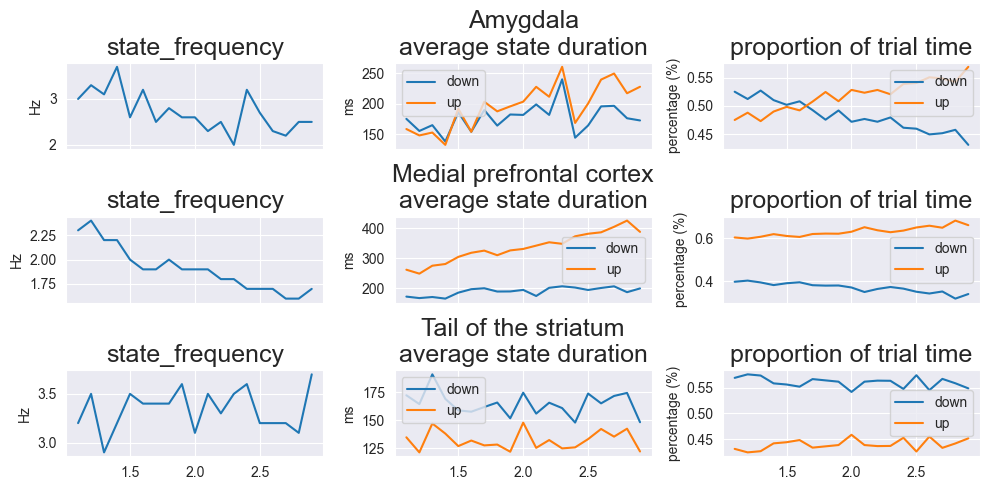

In [22]:
# choose one region and for this region plot the different parameter for different G values 
plot_parameter_statistics(all_analyses, regions=['Amygdala', 'Medial prefrontal cortex', 'Tail of the striatum'])

<AxesSubplot:xlabel='G', ylabel='brunel_X'>

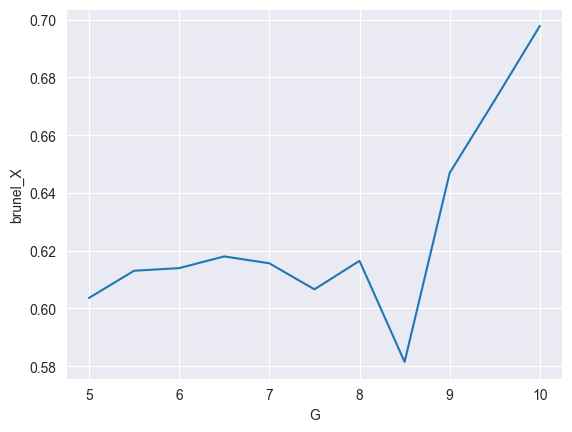

In [27]:
# plot the brunel X for different G params
sns.lineplot(brunel_X_df, x='G', y='brunel_X')

## Serotonin Stimulation

In [47]:
get_stimulation_window(file_dir, file_name)

array([[4848, 5847]], dtype=int64)

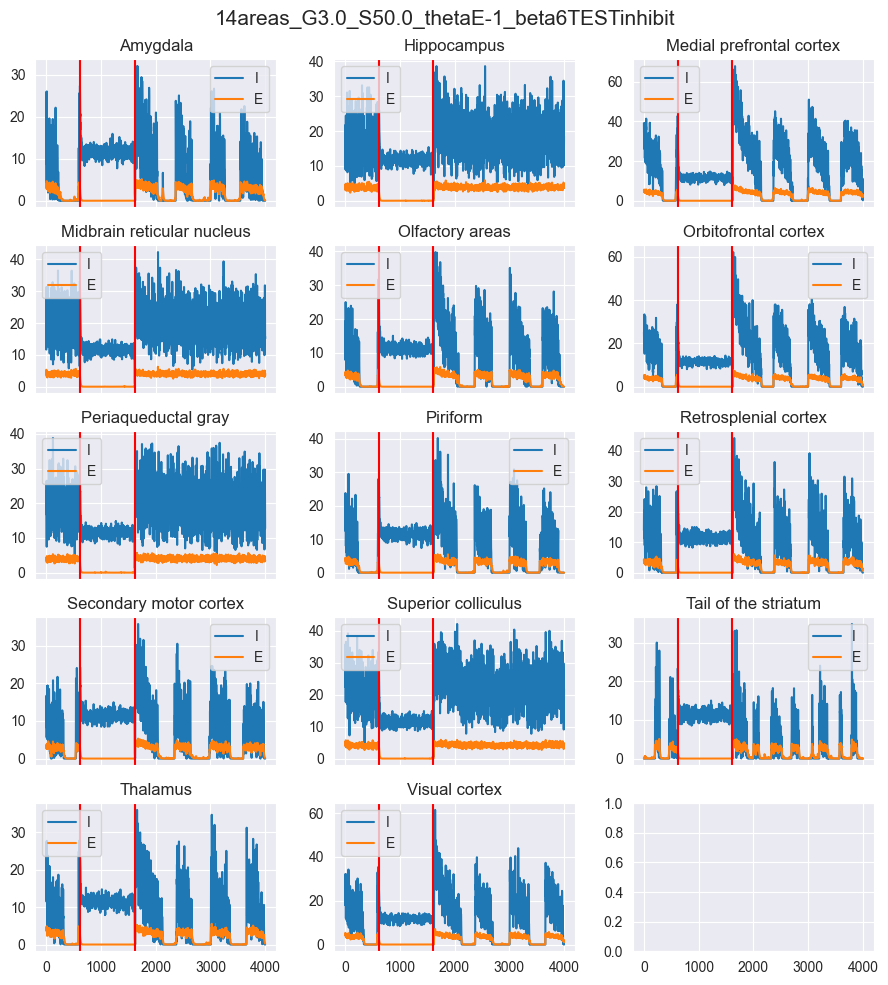

In [50]:
# load data
# plot signal of all regions for one simulation session
G = 0
S = 50
beta = 6
thetaE = -1
extra = "TESTinhibit"
start = 3000
stop = 7000
file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
file_dir = os.path.join(output_dir, file_name)
plot_multiarea_signal(file_dir, file_name, start, stop, states=False, stimulation=True)

The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

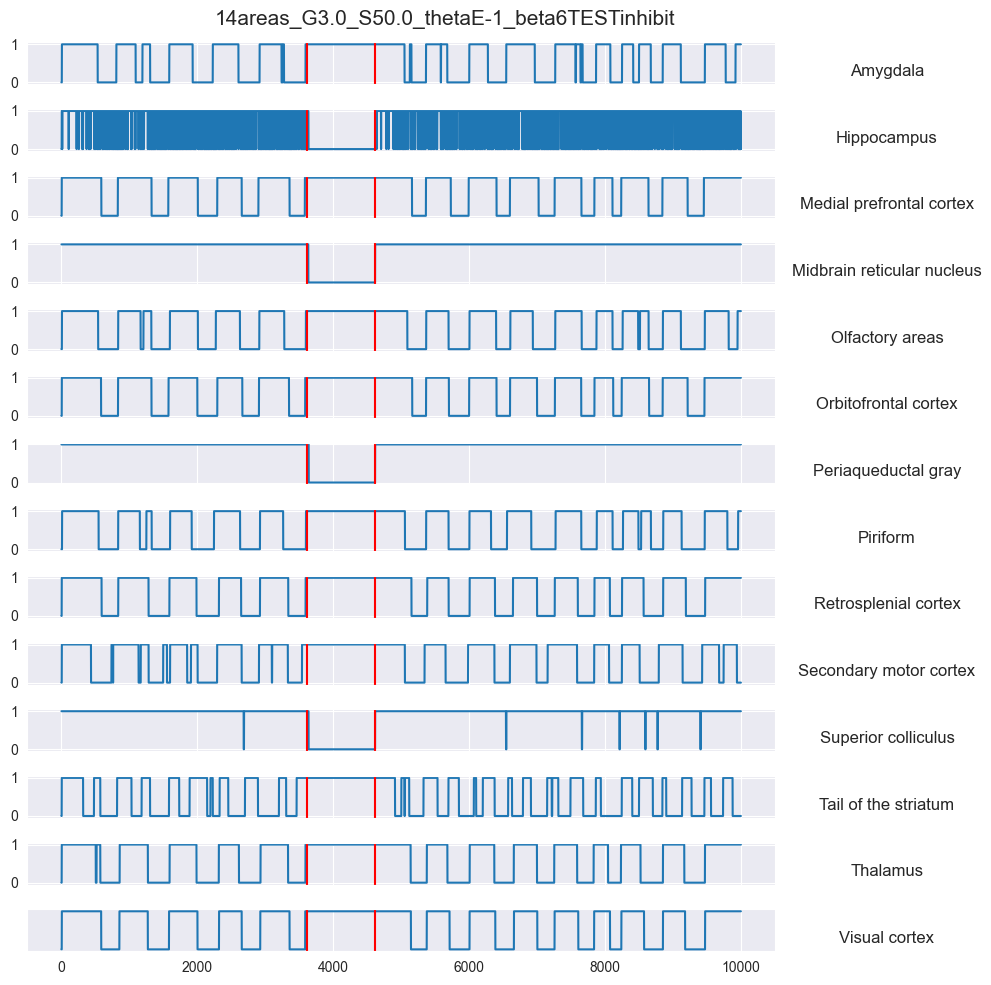

In [51]:
# choose one simulation session and plot the states of all regions in a column on top of each other
G = 3
S = 50
beta = 6
thetaE = -1
extra = "TESTinhibit"
file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
file_dir = os.path.join(output_dir, file_name)
#_ = get_all_states(file_dir, file_name)
plot_states_column(file_dir, file_name, stimulation=True)


Interesting parameters of serotonin stimulation:
- duration until next down state after stimulation start
- duration until next up state after stimulation end
- synchrony within the stimulation window 

In [7]:
# compute the paramters of serotonin stimulation for different G and S values
G_params = [0, 9]#np.arange(0, 10, 1)
S_params = np.arange(0, 100, 10)
serotonin_params = pd.DataFrame()

for G in G_params:
    for S in S_params:
        
        file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
file_dir = os.path.join(output_dir, file_name)
        serotonin_params = pd.concat((serotonin_params, compute_stimulation_parameter(file_dir, file_name)))
        

The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "states.csv"
The folder contains a file with the ending "stat

In [ ]:
# clean the dataset for analysis 

# only use the row where start of stimulation is on an up state and down is at an down state

In [10]:
serotonin_params

,dur_next_start,start_state,dur_next_stop,stop_state,region,G,S
0,97,1,110,0,Amygdala,10.0,2.0
0,14,0,95,0,Hippocampus,10.0,2.0
0,104,1,111,0,Medial prefrontal cortex,10.0,2.0
0,19,0,40,0,Midbrain reticular nucleus,10.0,2.0
0,96,1,113,0,Olfactory areas,10.0,2.0
...,...,...,...,...,...,...,...
0,103,1,86,0,Secondary motor cortex,10.0,2.0
0,78,1,94,0,Superior colliculus,10.0,2.0
0,366,0,75,0,Tail of the striatum,10.0,2.0
0,102,1,113,0,Thalamus,10.0,2.0


In [46]:
# calculate the states and synchrony quantification (brunel X parameter) for many different G values 
G_parameters = np.arange(1, 10, 1)
S_parameters = [0, 1, 1.5, 2]
all_analyses = pd.DataFrame()
brunel_X_df = pd.DataFrame()

for G in G_parameters:
    G_param = np.round(G, 1)
    
    for S in S_parameters:
        S_param = np.round(S, 1)
        file_name = f'14areas_G{float(G_param)}_S{float(S_param)}_thetaE{thetaE}_beta{beta}{extra}'
        file_dir = os.path.join(output_dir, file_name)
        
        # if there is no file containing the HMM states, compute them first
        # check if any files in the directory end with 'states.csv'
        if any(f.endswith('states.csv') for f in os.listdir(file_dir)):
            print('The folder contains a file with the ending "states.csv"')
        else:
            print('The folder does not contain a file with the ending "states.csv"')
            _ = get_all_states(file_dir, file_name)

        brunel_X_df = pd.concat((brunel_X_df, compute_brunel_x(file_dir, file_name)))
        all_analyses = pd.concat((all_analyses, compute_state_analysis(file_dir, file_name)))


The folder contains a file with the ending "states.csv"
network variance: 7.351632011991363
average of individual variance: 72.62222334808257
synchrony: 0.3181684481315416
The folder contains a file with the ending "states.csv"
network variance: 7.038321632588293
average of individual variance: 72.2392789551405
synchrony: 0.3121388696186995
The folder contains a file with the ending "states.csv"
network variance: 7.812429713385825
average of individual variance: 73.48370590506207
synchrony: 0.32606000912982724
The folder contains a file with the ending "states.csv"
network variance: 6.75452639225923
average of individual variance: 72.2193189956268
synchrony: 0.3058234315276497
The folder contains a file with the ending "states.csv"
network variance: 15.851987223975897
average of individual variance: 82.19963384890856
synchrony: 0.4391439614984421
The folder contains a file with the ending "states.csv"
network variance: 15.42667621782013
average of individual variance: 82.7939257471971


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

network variance: 180.643336665231
average of individual variance: 480.5679751877998
synchrony: 0.6131031678939384
The folder contains a file with the ending "states.csv"
network variance: 325.53572261580257
average of individual variance: 856.5780307772897
synchrony: 0.6164755554681834
The folder contains a file with the ending "states.csv"
network variance: 339.0271984261984
average of individual variance: 880.4776312646821
synchrony: 0.620523319185636
The folder contains a file with the ending "states.csv"
network variance: 342.18027242962785
average of individual variance: 883.3136687787312
synchrony: 0.6224006082364928
The folder contains a file with the ending "states.csv"
network variance: 258.6853080004216
average of individual variance: 740.9045312687248
synchrony: 0.5908874369760322
The folder contains a file with the ending "states.csv"
network variance: 867.1305125157423
average of individual variance: 2072.0289788461623
synchrony: 0.6469106809154945
The folder contains a f